# **3km_grid_map 생성**

* 한 변이 3km인 그리드들의 위도, 경도 키 값 얻기

* 해상에 해당하는 키값만 걸러내기

In [1]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 9.8 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 10.2 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelsp

In [2]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time
import copy
import math
import IPython
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install import_ipynb
import import_ipynb

%cd '/content/drive/MyDrive/Colab Notebooks/PathRecommendation/'

/content/drive/MyDrive/Colab Notebooks/PathRecommendation


### 1. 한 변이 3km인 그리드로 나눔

In [5]:
#대상 범위:(33, 125.5) ~ (35, 127.5)
base_lat = [33, 35]
base_lon = [125.5, 127.5]

#대상 범위 내 위도 1도와 경도 1도의 크기계산
earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490,
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188,
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

print(absolute_distance_pos)

[[0, 111.195, 111.195], [0, 96.49, 91.29]]


In [6]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]
gridmap_pivot_distance_km = 3 #그리드의 한 변이 3km가 되도록 나뉨

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(tlat != gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km - tlat
        elif(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lat.append(grid_lat[-1] + dlat)

        if(vlat <= 0):
            break

collection_grid_lat = [(grid_lat[i]-base_lat[0])*(base_lat[1]-grid_lat[-1])/(grid_lat[-1]-base_lat[0]) for i in range(0, len(grid_lat))]
grid_lat = [x+y for x,y in zip(grid_lat, collection_grid_lat)]

for ilon in range(1, len(absolute_distance_pos[1])):
    vlon = absolute_distance_pos[1][ilon]
    while(True):
        tlon = 0
        if(tlon != gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km - tlon
        elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
        else: tlon = vlon # vlon <= gridmap_pivot_distance_km

        vlon -= tlon
        dlon = tlon/lon_distance_per_one[(ilon//5)*5]

        grid_lon.append(grid_lon[-1] + dlon)

        if(vlon <= 0):
            break

collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/(grid_lon[-1]-base_lon[0]) for i in range(0, len(grid_lon))]
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]

print('Grid_latitude len: %d'%(len(grid_lat)))
print('Grid_longitude len: %d'%(len(grid_lon)))
print(grid_lat)
print(grid_lon)

Grid_latitude len: 77
Grid_longitude len: 65
[33.0, 33.026315789473685, 33.05263157894737, 33.078947368421055, 33.10526315789474, 33.13157894736842, 33.1578947368421, 33.18421052631579, 33.21052631578947, 33.23684210526316, 33.26315789473684, 33.28947368421053, 33.31578947368421, 33.3421052631579, 33.36842105263158, 33.39473684210526, 33.421052631578945, 33.44736842105263, 33.473684210526315, 33.5, 33.526315789473685, 33.55263157894737, 33.578947368421055, 33.60526315789474, 33.63157894736842, 33.6578947368421, 33.68421052631579, 33.71052631578947, 33.73684210526316, 33.76315789473684, 33.78947368421053, 33.81578947368421, 33.8421052631579, 33.86842105263158, 33.89473684210526, 33.921052631578945, 33.94736842105263, 33.973684210526315, 34.0, 34.026315789473685, 34.05263157894737, 34.078947368421055, 34.10526315789474, 34.13157894736842, 34.1578947368421, 34.18421052631579, 34.21052631578947, 34.23684210526316, 34.26315789473684, 34.28947368421053, 34.31578947368421, 34.3421052631579, 3

In [7]:
def draw_basemap_grid(lats, lons, m, color):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor=color, edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

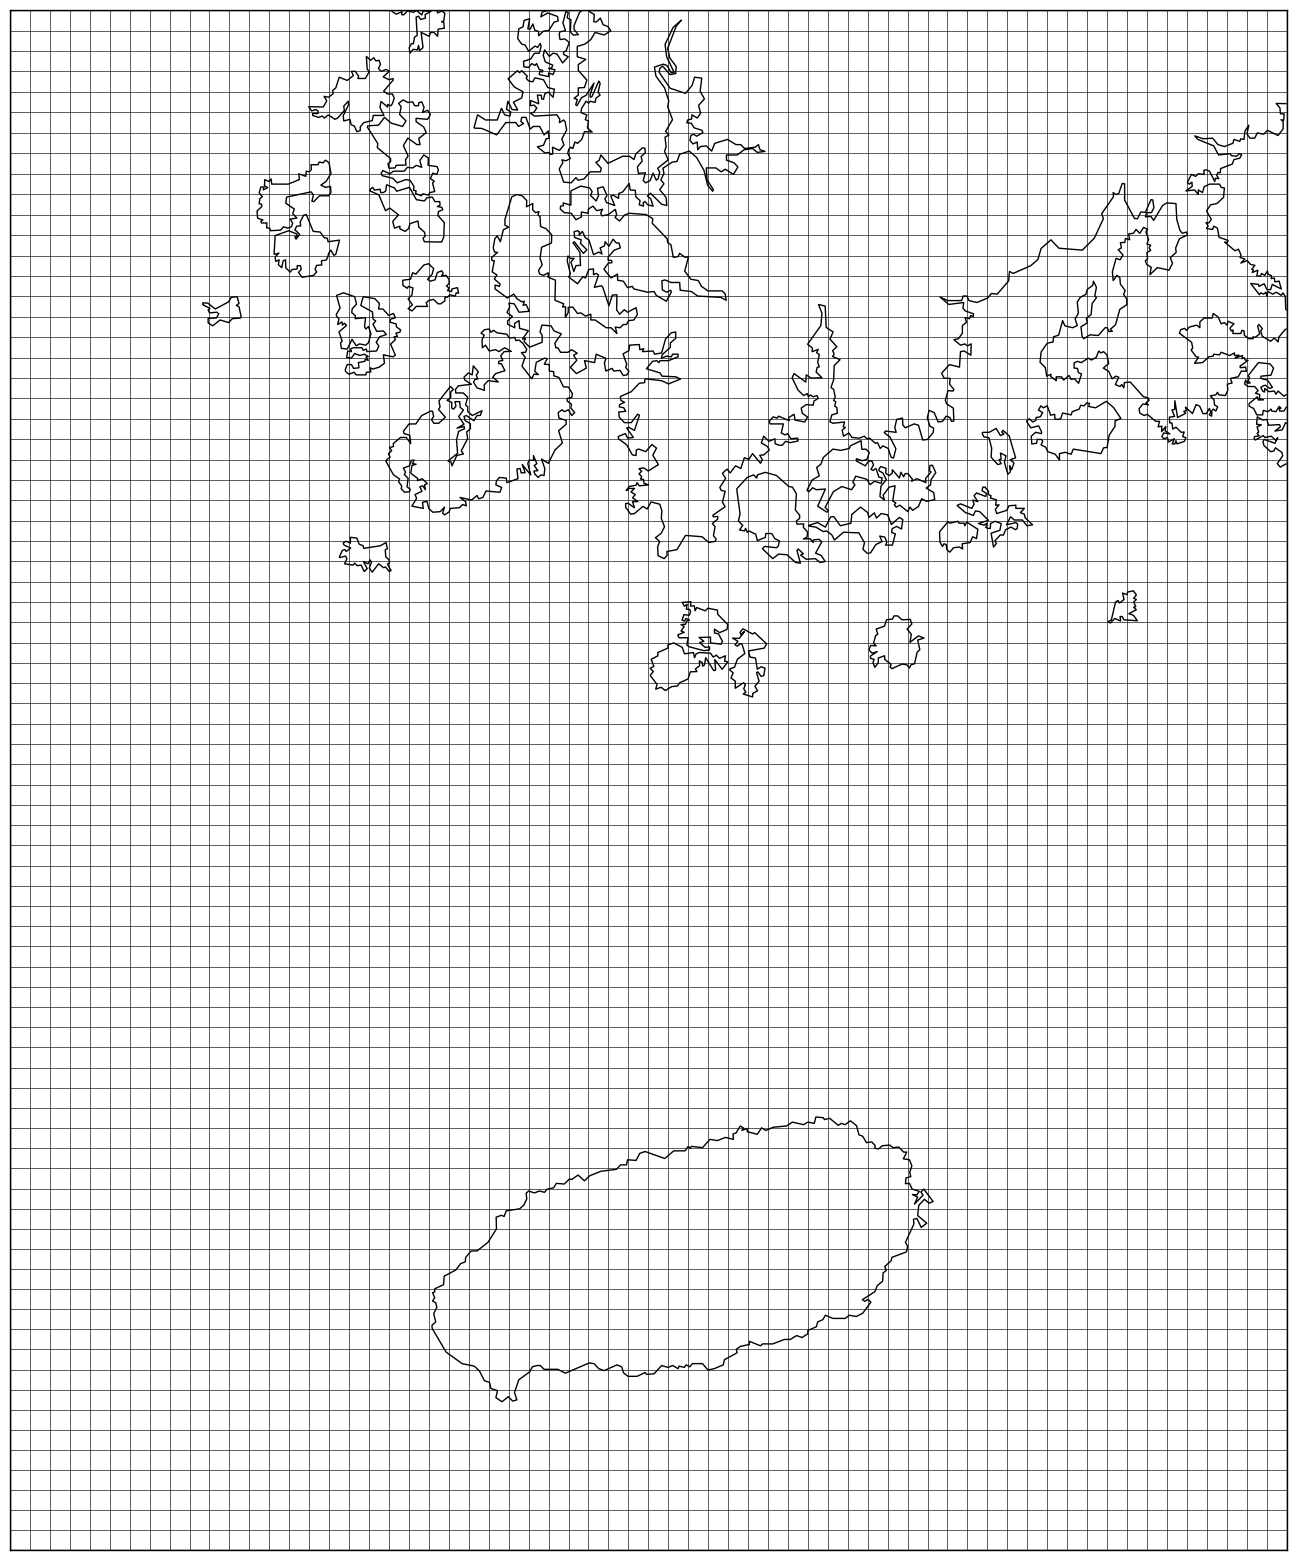

In [12]:
f = plt.figure(figsize=[20, 20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0],
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m, "none")

        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        # p, [], '', N, E, S, W, 유클리디안 거리, 영역, 수온, 최대파고, 유의파고, 평균파고, 파주기
        grid_map[key] = [p, [], '', 0, 0, 0, 0, 0, "", 0, 0, 0, 0, 0]

### 2. 육지 그리드 삭제

In [ ]:
with open('./files/sea_nodes.pkl', 'rb') as f:
    sea_nodes = pd.read_pickle(f)

In [ ]:
# 육지 그리드 삭제 함수
def delete_land_grids(grid_map, grid_lat, grid_lon):
    grid_keys_to_remove = []  # 삭제할 그리드 키 저장
    margin = 0.005

    for i, key in enumerate(grid_map.keys()):
        lat, lon = map(float, key.strip('()').split(','))

        # 현재 그리드의 경계 좌표 설정
        grid_lat_min = lat
        grid_lat_max = lat + (grid_lat[1] - grid_lat[0])
        grid_lon_min = lon
        grid_lon_max = lon + (grid_lon[1] - grid_lon[0])

        # 그리드 내부에 해상 노드가 포함되는지 확인
        if not any(
            (grid_lat_min - margin) <= node[0] <= (grid_lat_max + margin) and
             (grid_lon_min - margin) <= node[1] <= (grid_lon_max + margin) for node in sea_nodes
        ):
            grid_keys_to_remove.append(key)

    for key in grid_keys_to_remove:
        del grid_map[key]

    return grid_map

In [ ]:
print(len(grid_map))
grid_map = delete_land_grids(grid_map, grid_lat, grid_lon) #육지 삭제
print(len(grid_map))

4864
4147


In [ ]:
#저장
with open('./files/grid_lon_3km.pkl', 'wb') as f:
        pickle.dump(grid_lon, f)
with open('./files/grid_lat_3km.pkl', 'wb') as f:
        pickle.dump(grid_lat, f)
with open('./files/grid_map_3km.pkl', 'wb') as f:
        pickle.dump(grid_map, f)

grid_lat_lon_keys = list(grid_map.keys())
with open('./files/grid_lat_lon_keys_3km.pkl', 'wb') as f:
        pickle.dump(grid_lat_lon_keys, f)

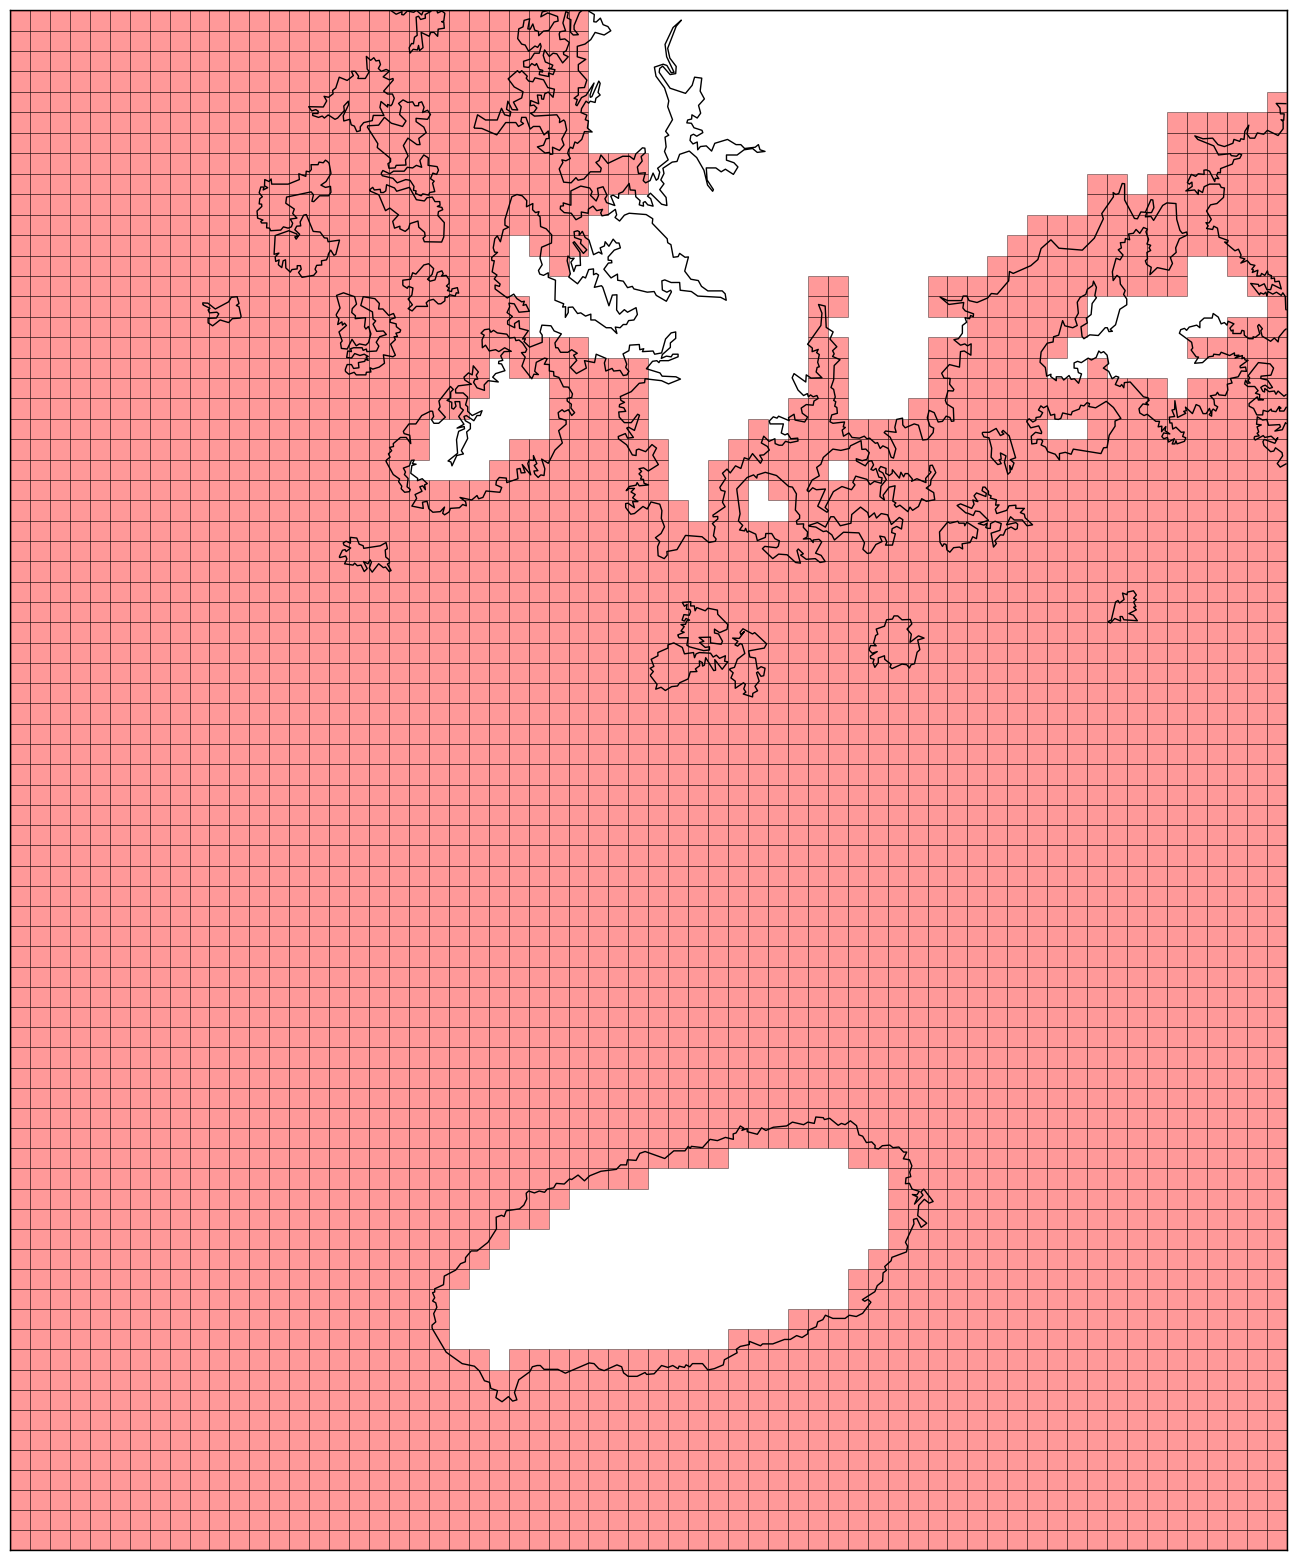

In [ ]:
# 육지 삭제 후 그리드 시각화
f = plt.figure(figsize=[20, 20])
m = Basemap(llcrnrlon=base_lon[0], llcrnrlat=base_lat[0],
            urcrnrlon=base_lon[1], urcrnrlat=base_lat[1],
            resolution='h', projection='merc')

for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        key = '(%f,%f)' % (grid_lat[ilat-1], grid_lon[ilon-1])

        if key in grid_map:
            draw_basemap_grid(lats, lons, m, "r")

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()
plt.show()